In [1]:
import matplotlib.pyplot as plt
import numba as nb
import numpy  as np
import pandas as pd
from scipy import optimize
%matplotlib inline

import binopt
from scipy import special as sp


In [2]:
csv = np.genfromtxt ('BDTscores_2017muon_100bins.csv', delimiter=",")
bins = csv[:,0]
data = csv[:,1]
mc = csv[:,2]

In [3]:
s = data
b = mc

X = np.concatenate([bins,bins])
W = np.concatenate([s,b])
Y = np.concatenate([np.ones(s.shape[0]), np.zeros(b.shape[0])])

In [4]:
b

array([  0.665183,   0.742585,   0.724792,   1.095423,   0.927903,
         1.005623,   1.764736,   0.789544,   1.897838,   2.155896,
         1.515903,   3.175824,   2.726853,   2.391383,   3.398652,
         2.962755,   3.659186,   2.285047,   3.477938,   2.966612,
         2.813888,   3.755576,   4.124183,   3.88744 ,   2.358675,
         3.136719,   3.14785 ,   3.60461 ,   4.040238,   3.559132,
         3.490613,   3.670415,   2.871276,   4.098191,   3.924961,
         3.787658,   4.001846,   3.610958,   5.003127,   4.157159,
         3.80087 ,   5.237944,   4.723979,   5.04465 ,   4.955756,
         5.939197,   4.385484,   6.207986,   5.627931,   4.787606,
         3.537832,   5.559675,   5.771263,   6.255916,   5.310774,
         5.312395,   5.467187,   6.75885 ,   6.485685,   6.287737,
         7.450549,   6.527717,   6.50904 ,   7.720239,   7.342269,
         6.988527,   7.739201,   9.319342,   6.494795,   6.123858,
         9.889768,   9.700151,  10.357779,   9.987059,  10.340

In [5]:
edge_bins = np.arange(0,1.01, 0.01)

In [7]:
viv_get_equiprobable_binning(s, edge_bins, 32)

Will not return 32 bins.
Too many events in bins [0 1 3 6]
Returning with 20 bins


(array([5770.,  761.,  720.,  769.,  791.,  753.,  776.,  669.,  691.,
         703.,  653.,  607.,  556.,  512.,  530.,  502.,  485.,  867.,
         786.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.19, 1.  ]))

In [13]:
viv_get_equiprobable_binning(b, edge_bins, 22)

Will not return 22 bins.
Too many events in bins [17 19]
Returning with 21 bins


(array([ 46.89914 ,  49.701961,  46.475486,  52.756862,  45.486765,
         51.728231,  50.274845,  40.933465,  57.001946,  31.354267,
         60.589781,  49.172908,  25.624951,  62.960305,  37.626759,
         44.509102,  51.146334,  61.242301,  80.164119, 157.269842]),
 array([0.  , 0.22, 0.36, 0.46, 0.56, 0.63, 0.7 , 0.75, 0.79, 0.83, 0.85,
        0.88, 0.9 , 0.91, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 1.  ]))

In [6]:
def viv_get_equiprobable_binning(bin_heights, bin_edges, nbins):
    cdf = np.cumsum(bin_heights)
    target_events = cdf[-1] / nbins

    bin_idxs = []
    for idx in range(1, nbins):
        target_bin = np.argmin(np.abs(cdf - idx * target_events))
        bin_idxs.append(target_bin)
   
    if (len(bin_edges) - 1) not in bin_idxs:
        bin_idxs.append(len(bin_edges) - 1)
    if [0] not in bin_idxs:
        bin_idxs = [0] + bin_idxs
        
    bin_idxs_arr, counts = np.unique(np.array(bin_idxs, dtype=np.int32),
                                     return_counts=True)
    big_bins = np.where(counts > 1)[0]
    if big_bins.size > 0:
        print(f'Will not return {nbins} bins.')
        print(f'Too many events in bins {big_bins}')
        print(f'Returning with {len(bin_idxs_arr)} bins')
    equi_bin_edges = bin_edges[bin_idxs_arr]
    
    new_bin_heights = []
    for lower, upper in zip(bin_idxs_arr[:-1], bin_idxs_arr[1:]):
        new_bin_heights.append(bin_heights[lower:upper].sum())
 
    return np.array(new_bin_heights), equi_bin_edges

In [331]:
def viv_equiprobable_binning_cost(nbins, bin_heights):
    cdf = np.cumsum(bin_heights)
    target_events = cdf[-1] / nbins

    bin_idxs = []
    for idx in range(1, nbins):
        target_bin = np.argmin(np.abs(cdf - idx * target_events))
        bin_idxs.append(target_bin)

    bin_idxs_arr= np.unique(bin_idxs).astype(np.int32)
    
    new_bin_heights = []
    for lower, upper in zip(bin_idxs_arr[:-1], bin_idxs_arr[1:]):
        new_bin_heights.append(bin_heights[lower:upper].sum())

    probabilities = new_bin_heights / cdf[-1]
        
    return -np.sum(probabilities * np.log(probabilities))

In [334]:
rng = np.random.default_rng(0)
rands = rng.beta(1/2, 1/2, size=10000)
dx = 1e-2
bin_heights, bins = np.histogram(rands, bins=np.arange(0, 1, dx))

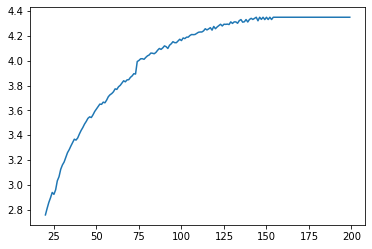

In [335]:
rang = np.arange(20, 200, 1)
plt.plot(rang,
         [viv_equiprobable_binning_cost(x, bin_heights) for x in rang])

In [256]:
new_bin_heights, equi_bin_edges = viv_get_equiprobable_binning(bin_heights, bins, 100)

In [257]:
new_bin_heights

array([152, 105, 121, 104, 101, 102,  99, 110,  98,  93, 103, 107,  95,
       101, 103,  99, 103,  97, 103,  97, 105,  98,  98, 104,  98, 100,
        99, 102, 101, 100, 100, 100,  99,  99,  99, 103, 100,  99,  99,
       100, 103,  99,  97, 103, 101,  97,  99, 104,  99,  98, 102, 100,
       100,  99, 100, 101, 100, 101,  98, 102,  99, 100, 100, 100,  99,
       102,  98, 100, 101, 100, 101, 100,  99,  99, 102,  97, 102, 100,
       100, 100,  99, 100, 101, 101,  98, 102,  99, 100, 100, 100, 101,
       100,  99, 101, 100, 100, 100, 100, 101])

In [249]:
len(new_bin_heights)

55

In [225]:
len(new_bin_heights)

55

In [226]:
len(equi_bin_edges)

56

In [203]:
bin_heights

array([152,  67,  38, ...,   0,   0,   0])

In [138]:
x, y = getEquiprobableBinning(bin_heights[None,:], bins[:-1], 20)

In [101]:
def getEquiprobableBinning(entryArray, edgesArray, nEquiprobableBins, includeOverflow=False, includeUnderflow=False, verbose=False):
    if includeUnderflow:
        start = 0
    else:
        start = 1 #Don't include underflow
    stop = start + 1 #Initialize so that we start with checking the singular bin
    if includeOverflow:
        end = len(edgesArray) - 1 #nBinsX + 1 #one less since edgesArray is 1 greater than the entryArray in the same dimension
    else:
        end = len(edgesArray) - 1
    binningArray = []
    with np.errstate(divide='ignore'):
        cdf = np.cumsum(entryArray, axis=1)
        if start > 0:
            cdf = cdf - cdf[:, 0] #adjust according to underflow selection
        target = cdf[:, end] / np.int64(nEquiprobableBins)
        #Only use the 0th systematic (nominal) to calculate things
        binningArray.append(start)
        for x in range(1, nEquiprobableBins):
            targetBin = np.argmin(np.abs(cdf[0, :] - x * target))
            binningArray.append(min(end-1, max(binningArray[-1]+1, targetBin)))
        binningArray.append(end)
        # print(binningArray)
        if verbose: 
            print("Binning Array: {}".format(binningArray))
            print("Numpy Entry Array: {}".format(entryArray))
    ret = edgesArray[np.array(binningArray, dtype=np.int32)]
    # print(ret)
    temp = cdf[0, np.array(binningArray, dtype=np.int32)]
    # print("integrals:", temp[1:] - temp[:-1])
    return binningArray, ret

In [110]:
bin_arr, equi_bins = getEquiprobableBinning(v, edge_bins[:-2], 25, includeUnderflow=False)

In [111]:
new_bin_sizes = []
for lower, upper in zip(bin_arr[:-1], bin_arr[1:]):
    new_bin_sizes.append(b[lower:upper].sum())

In [112]:
new_bin_sizes

[1020.128426,
 1084.463797,
 1074.988926,
 1103.239887,
 1087.503779,
 1003.870232,
 1844.8574800000001,
 1477.829283,
 787.116619,
 1497.118365,
 1259.3542830000001,
 1470.739249,
 1573.412108,
 1413.860778,
 1357.0735020000002,
 1202.657158,
 1247.589795,
 1414.9076340000001,
 1382.565897,
 1339.0445,
 1315.129879,
 1169.195001,
 1477.2934599999999,
 1246.77314,
 1319.765896]

In [97]:
v

array([[8620.020935, 1020.128426, 1084.463797, 1074.988926, 1103.239887,
        1087.503779, 1003.870232,  985.844982,  859.012498,  708.677302,
         769.151981,  787.116619,  807.186542,  689.931823,  685.312377,
         574.041906,  744.070915,  726.668334,  514.26769 ,  523.077906,
         536.066512,  508.351326,  491.216324,  414.293128,  391.3571  ,
         474.613475,  491.102927,  482.400654,  360.740522,  359.515982,
         330.356393,  339.990589,  279.142561,  298.100252,  279.111716,
         332.423192,  263.839407,  280.781338,  258.751981,  327.254793,
         298.820927,  203.256808,  196.138512,  357.094857,  201.607049,
         202.531689,  276.262822,  263.604375,  185.625636,  209.412929,
         191.518805,  233.818538,  182.366026,  235.730535,  143.379492,
         170.511101,  157.805382,  206.618211,  171.265437,  178.016885,
         165.569835,  166.305603,  172.669359,  108.749671,  176.469505,
         151.174988,  163.523523,  134.464071,  155

In [100]:
v.ravel()

array([8620.020935, 1020.128426, 1084.463797, 1074.988926, 1103.239887,
       1087.503779, 1003.870232,  985.844982,  859.012498,  708.677302,
        769.151981,  787.116619,  807.186542,  689.931823,  685.312377,
        574.041906,  744.070915,  726.668334,  514.26769 ,  523.077906,
        536.066512,  508.351326,  491.216324,  414.293128,  391.3571  ,
        474.613475,  491.102927,  482.400654,  360.740522,  359.515982,
        330.356393,  339.990589,  279.142561,  298.100252,  279.111716,
        332.423192,  263.839407,  280.781338,  258.751981,  327.254793,
        298.820927,  203.256808,  196.138512,  357.094857,  201.607049,
        202.531689,  276.262822,  263.604375,  185.625636,  209.412929,
        191.518805,  233.818538,  182.366026,  235.730535,  143.379492,
        170.511101,  157.805382,  206.618211,  171.265437,  178.016885,
        165.569835,  166.305603,  172.669359,  108.749671,  176.469505,
        151.174988,  163.523523,  134.464071,  155.69322 ,  196.